## Blending Validation
---

WISE has big pixels, which means that oftentimes a reported WISE photometry captures more than one star. unWISE claims to do better than AllWISE in that respect, and I want to test that claim here. The gold standard for IR photometry is the Spitzer S-COSMOS IRAC 4-channel photometry. I'd like to cross-match unWISE against that and figure out what cuts are necessary.

https://irsa.ipac.caltech.edu/data/COSMOS/gator_docs/cosmos2020c_colDescriptions.html

In [1]:
# general python imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# general astronomy imports
from astropy.io import fits
from astropy.table import Table, join, join_skycoord, unique, vstack, hstack
import pyphot
from pyphot import unit
from pyvo import registry  # version >=1.4.1 
from astroquery.gaia import Gaia
from astroquery.xmatch import XMatch
import corv

plt.style.use('stefan.mplstyle')

Could not import regions, which is required for some of the functionalities of this module.
/home/arsen/miniconda3/envs/ir-excess/lib/python3.12/site-packages/corv/models/warwick_da
We could not find the pickled WD models
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [24]:
# read the xmatched columns
test_catalog = Table.read('data/S-COSMOS_unWISE_WDs.tbl', format='ipac')

WDs with WISE observations: 31


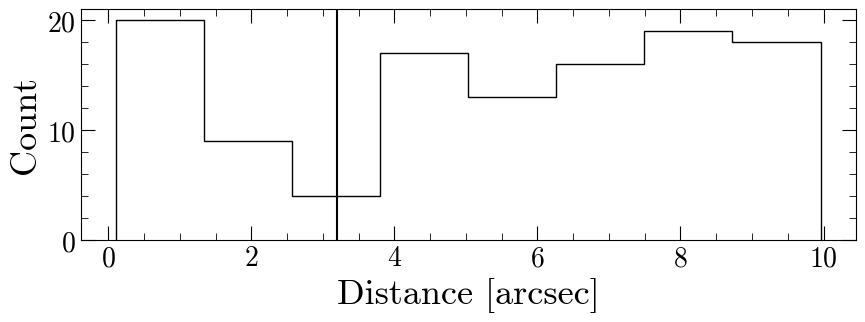

In [25]:
# choose only the real matches
angdist = 3.2 # maximum angular distance

plt.figure(figsize = (10,3))
plt.hist(test_catalog['dist_x'], color = 'k', histtype = 'step')
plt.axvline(x = angdist, c = 'k')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')

test_catalog = test_catalog[test_catalog['dist_x'] < angdist]
print(f'WDs with WISE observations:', len(test_catalog))

In [58]:
# signal-to-noise ratio is flux over error
test_catalog['w1snr'] = test_catalog['flux_1_01'] / test_catalog['dflux_1_01'];
test_catalog['w2snr'] = test_catalog['flux_2_01'] / test_catalog['dflux_2_01'];

# convert to magnitudes, see p.15 of https://ui.adsabs.harvard.edu/abs/2019ApJS..240...30S/abstract
test_catalog['w1mpro'] = 22.5 - 2.5*np.log10(test_catalog['flux_1_01'])
test_catalog['w2mpro'] = 22.5 - 2.5*np.log10(test_catalog['flux_2_01']) 

# calculate magnitude uncertainties
test_catalog['w1sigm'] = test_catalog['dflux_1_01'] / (1.09 * test_catalog['flux_1_01']);
test_catalog['w2sigm'] = test_catalog['dflux_2_01'] / (1.09 * test_catalog['flux_2_01']);

/tmp/ipykernel_15688/4170305923.py:6: RuntimeWarning: divide by zero encountered in log10
  test_catalog['w1mpro'] = 22.5 - 2.5*np.log10(test_catalog['flux_1_01'])
/tmp/ipykernel_15688/4170305923.py:7: RuntimeWarning: divide by zero encountered in log10
  test_catalog['w2mpro'] = 22.5 - 2.5*np.log10(test_catalog['flux_2_01'])


In [61]:
lib = pyphot.get_library()
f = [lib['WISE_RSR_W1'], lib['WISE_RSR_W2']] # define the WISE filters

# 1 nMgy = 3.631e-6 Jy = (3.631e-6)e6 uJy = 3.631 Jy
test_catalog['w1_ujy'] = 309.5e6 * 10**(-test_catalog['w1mpro'] / 2.5)
test_catalog['w2_ujy'] = 171.7e6 * 10**(-test_catalog['w2mpro'] / 2.5)

# propagate nMgy -> uJy uncertainty
test_catalog['dw1_ujy'] = test_catalog['w1sigm'] * (1.09 * test_catalog['w1_ujy'])
test_catalog['dw2_ujy'] = test_catalog['w2sigm'] * (1.09 * test_catalog['w2_ujy'])


In [77]:
# convert S-COSMOS flux to useable units
test_catalog['flux_c1'] = test_catalog['flux_c1_1'] / 0.610
test_catalog['flux_c2'] = test_catalog['flux_c2_1'] / 0.590

test_catalog['dflux_c1'] = test_catalog['err_c1_1'] / 0.610
test_catalog['dflux_c2'] = test_catalog['err_c2_1'] / 0.590


# compute chi^2 metric
test_catalog['chi2_w1'] = (test_catalog['w1_ujy'] - test_catalog['flux_c1'])**2 / (test_catalog['dw1_ujy']**2 + test_catalog['dflux_c1']**2)
test_catalog['chi2_w2'] = (test_catalog['w2_ujy'] - test_catalog['flux_c2'])**2 / (test_catalog['dw2_ujy']**2 + test_catalog['dflux_c2']**2)

test_catalog.sort('fracflux_1_01')

In [82]:
test_catalog[['w1_ujy', 'dw1_ujy', 'flux_c1', 'dflux_c1', 'chi2_w1']]

w1_ujy,dw1_ujy,flux_c1,dflux_c1,chi2_w1
,,uJy,uJy,
float64,float64,float64,float64,float64
29.39104850000008,2.453066050000007,26.229508196721312,0.14754098360655737,1.6550485640497745
27.400344500000063,2.3340942500000055,17.19672131147541,0.13114754098360656,19.05035664390837
31.52567000000004,2.385842650000003,37.622950819672134,0.18032786885245902,6.494038531409887
20.678313999999993,2.3596898999999993,14.62295081967213,0.14754098360655737,6.559579238032703
16.899937999999988,2.2841409499999985,13.754098360655739,0.11475409836065575,1.8920498725260835
40.82924000000007,2.4426978000000044,41.39344262295082,0.18032786885245902,0.05306037273337245
64.93929,2.4500329499999998,47.721311475409834,0.18032786885245902,49.12178332713283
90.92800500000023,2.5460089000000066,75.37704918032786,0.21311475409836067,37.047765925951666


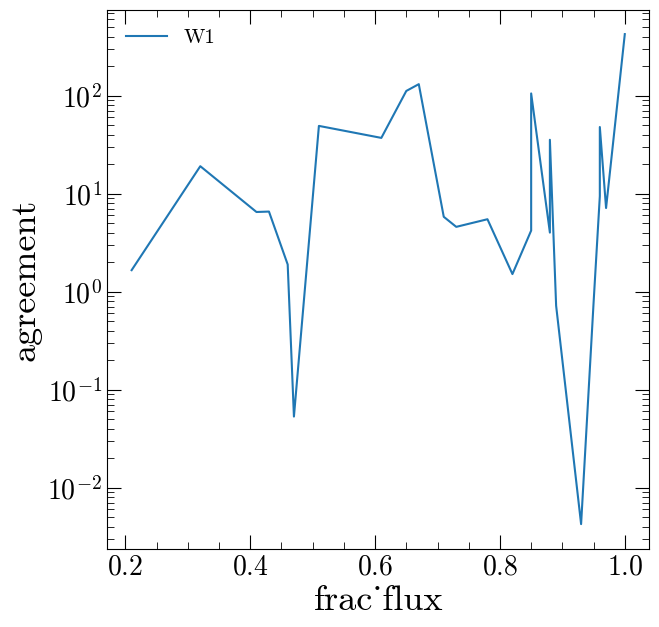

In [83]:
plt.plot(test_catalog['fracflux_1_01'], test_catalog['chi2_w1'], label='W1')

plt.xlabel('frac_flux')
plt.ylabel('agreement')
plt.yscale('log')
plt.legend(framealpha=0)